CLASIFICACION DE IMAGENES DE ANIMALES SIN COLOR (10 CATEGORIAS)

In [ ]:
# Importamos librerias
import pandas as pd
import os

import boto3
import sagemaker

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


2025-06-17 19:19:04.968948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 19:19:14.852848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 19:19:14.934181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 19:19:27.848105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 19:19:42.704559: W tensorflow/com

In [ ]:
# identificacion de region
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

# indetificacion de rol
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

# sesion de sagemaker
sagemaker_session = sagemaker.Session()

AWS Region: sa-east-1
RoleArn: arn:aws:iam::311141559468:role/Rol-AccesoTotal


In [ ]:
import boto3

# Crear cliente S3
s3 = boto3.client('s3')

# Nombre del bucket en aws
bucket = 'imagenes-deeplearning-2025'

# Listamos objetos en el bucket
response = s3.list_objects_v2(Bucket=bucket)

# Verificar si hay objetos en el bucket, debe encontrar el archivo Zip que contine las imagenes
if 'Contents' in response:
    # Imprimir las claves de los objetos
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No se encontraron objetos en el bucket.")


animales.zip


In [ ]:
import os
import zipfile
import shutil
import random
import boto3

# --- Configuracion para importar las imagenes a JupyterLab---
BUCKET = 'imagenes-deeplearning-2025'
ZIP_KEY = 'animales.zip'
LOCAL_ZIP = 'animales_temp.zip'
EXTRACT_FOLDER = 'temp_dataset'
SPLIT_FOLDER = 'dataset_split'


# Para realizar una division de los datos 
SPLITS = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}
SEED = 123

random.seed(SEED)
s3 = boto3.client('s3')

In [ ]:
# --- Descargamos el archivo el Zip ---
s3.download_file(BUCKET, ZIP_KEY, LOCAL_ZIP)
print(" Archivo Zip descargado")

: 

In [ ]:
# --- Descomprimimos el archivo Zip y lo guardamos en temp_dataset ---
with zipfile.ZipFile(LOCAL_ZIP, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_FOLDER)
print("ZIP descomprimido")

ZIP descomprimido


In [ ]:
# --- Preparamos la carpetas destino dataset_split para el split ---
for split in SPLITS:
    os.makedirs(os.path.join(SPLIT_FOLDER, split), exist_ok=True)

In [ ]:
# --- Dividimos en clases ---
SOURCE_DIR = EXTRACT_FOLDER  

for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    for split in SPLITS:
        os.makedirs(os.path.join(SPLIT_FOLDER, split, class_name), exist_ok=True)

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * SPLITS['train'])
    val_end = train_end + int(total * SPLITS['val'])

    split_data = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, image_list in split_data.items():
        for img in image_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(SPLIT_FOLDER, split, class_name, img)
            shutil.copy2(src, dst)

print("Dataset dividido en train / val / test")

Dataset dividido en train / val / test


In [ ]:
# --- Subimos a S3 ---
for root, dirs, files in os.walk(SPLIT_FOLDER):
    for file in files:
        local_path = os.path.join(root, file)
        relative_path = os.path.relpath(local_path, SPLIT_FOLDER)
        s3_key = f"dataset_split/{relative_path}".replace("\\", "/")
        s3.upload_file(local_path, BUCKET, s3_key)
        print(f"Subido a s3://{BUCKET}/{s3_key}")

Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-1oZM5Z39NBJVzrp8QJCyNQCoEs.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-rQC_l5phMQ0YTDnXwuYP6AHaFj.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-49EzwfQF4PfsCfNjoR4WMAEsDZ.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-7PflA-0CUOe_CqSKgIkzlwHaLH.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-s4ZREMDAaPCD8LV5J5LROAHaGn.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-pHY8kUqE1GlWY5mk_Fbs7QHaHw.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-wjqzNfBzze1ZkokVFy11dQHaFj.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-ni5mYfUoNo0KVaOj2tjqugHaJ4.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-Q6m0QlkDEdGLNm-KtXlnzwHaEK.jpeg
Subido a s3://imagenes-deeplearning-2025/dataset_split/train/perro/OIP-rf

In [ ]:
# --- Limpiamos las carpetas temporales ---
os.remove(LOCAL_ZIP)
shutil.rmtree(EXTRACT_FOLDER)
#shutil.rmtree(SPLIT_FOLDER)
print("Archivos temporales eliminados")

print("Dataset dividido y subido a S3.")

In [ ]:
import tensorflow as tf
import sagemaker
from sagemaker import get_execution_role


# Parámetros
batch_size = 32
img_height = 180
img_width = 180

# --- Configuramos ruta S3 ---
#bucket = 'imagenes-deeplearning-2025'
#s3_dataset_path = f's3://imagenes-deeplearning-2025/dataset_split/'

#Trabajamos de forma local
s3_dataset_path ='dataset_split/'

# ==== Función para convertir imágenes a escala de grises (1 canal) ====
def to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)  # (H, W, 1)
    return image, label


train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    s3_dataset_path + 'train/',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb"
)
train_class_names = train_ds_raw.class_names
train_ds = train_ds_raw.map(to_grayscale)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    s3_dataset_path + 'val/',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb"
)
val_class_names = val_ds_raw.class_names
val_ds = val_ds_raw.map(to_grayscale)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    s3_dataset_path + 'test/',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb"
)
test_class_names = test_ds_raw.class_names
test_ds = test_ds_raw.map(to_grayscale)


Found 18322 files belonging to 10 classes.


2025-06-17 19:21:28.375446: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 3922 files belonging to 10 classes.
Found 3935 files belonging to 10 classes.


Matplotlib is building the font cache; this may take a moment.


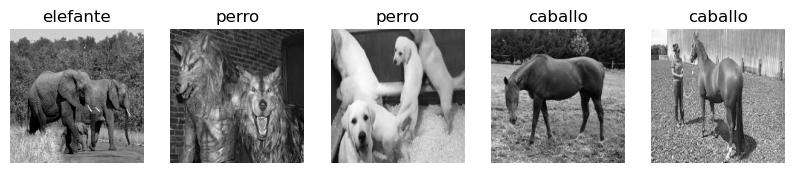

In [ ]:
import matplotlib.pyplot as plt

# Graficamos las primeras 5 images del primer lote
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(train_class_names[labels[i].numpy()])
        plt.axis("off")
    break

In [ ]:
# Verificamos el formato de las imagenes
for images, labels in train_ds.take(1):
    for i in range(min(2, len(images))):
        print(images[i].shape)
        imagen = images[i].numpy().astype("uint8")
        print(imagen.shape)

(180, 180, 1)
(180, 180, 1)
(180, 180, 1)
(180, 180, 1)


2025-06-17 19:22:40.029208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Realizamos el modelo de redes neuronales
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(train_class_names))  # una salida por clase
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

In [ ]:
# Guardamos el modelo como model_anim.h5
model.save("model_anim.h5")
print("Modelo guardado como model_anim.h5")

Modelo guardado como model_anim.h5


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Hacemos llamado del modelo para ejecutarlo
modelo = tf.keras.models.load_model("model_anim.h5")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np

# Cargamos una imagen aletoria y la convertimos en escala de grises para una mejor prueba
img_path = "vaca1.PNG"

# Cargar imagen y convertir a escala de grises
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (180, 180))
img_array = np.expand_dims(img, axis=-1)  # agrega canal (1)
img_array = np.expand_dims(img_array, axis=0)  # agrega batch (1, 180, 180, 1)

In [38]:
img_array.shape

(1, 180, 180, 1)

In [39]:
img_array

array([[[[ 41],
         [ 62],
         [ 64],
         ...,
         [ 43],
         [ 22],
         [ 24]],

        [[ 42],
         [ 63],
         [ 53],
         ...,
         [ 35],
         [ 30],
         [ 41]],

        [[ 42],
         [ 39],
         [ 35],
         ...,
         [ 35],
         [ 35],
         [ 29]],

        ...,

        [[111],
         [107],
         [101],
         ...,
         [114],
         [135],
         [145]],

        [[120],
         [117],
         [103],
         ...,
         [144],
         [170],
         [203]],

        [[121],
         [123],
         [ 77],
         ...,
         [151],
         [178],
         [202]]]], dtype=uint8)

In [ ]:
# Realizamos la prediccion con la imagen aletoria, vemos que nos da una confianza del 99,73%
predictions = modelo.predict(img_array)
print(predictions)
probabilities = tf.nn.softmax(predictions[0])
predicted_index = np.argmax(probabilities)
predicted_class = train_class_names[predicted_index]

print(f"Clase predicha: {predicted_class} ({predicted_index})")
print(f"Confianza: {100 * np.max(probabilities):.2f}%")

1/1 [==============================] - 0s 28ms/step
[[ -5.2941737 -32.37996    21.557985  -15.026186   -2.8193843  -9.837628
    6.7588444   9.556899   12.824846   27.465311 ]]
Clase predicha: vaca (9)
Confianza: 99.73%
